In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib


In [2]:
# Define the path to the Excel file
file_path = r"C:\Users\nithi\OneDrive\Documents\Churn Analysis.xlsx"

# Define the sheet name to read data from
sheet_name = 'vw_ChurnData'

# Read the data from the specified sheet into a pandas DataFrame
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the fetched data
print(data.head())


  Customer_ID  Gender  Age Married            State  Number_of_Referrals  \
0   11340-JAM  Female   21      No  Jammu & Kashmir                    8   
1   11348-MAH  Female   46      No      Maharashtra                   11   
2   11359-AND  Female   28     Yes   Andhra Pradesh                    3   
3   11370-TAM  Female   21      No       Tamil Nadu                   15   
4   11392-JAM  Female   39     Yes  Jammu & Kashmir                   11   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7        NaN           Yes             No  ...   
1                19     Deal 3           Yes             No  ...   
2                 6     Deal 4           Yes             No  ...   
3                10     Deal 4           Yes             No  ...   
4                 1     Deal 2           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal      19.950001    219.500000           0.0   
1  B

In [3]:
data = data.drop(
    columns=['Customer_ID', 'Churn_Category', 'Churn_Reason'],
    errors='ignore'
)


In [4]:
data['Customer_Status'] = data['Customer_Status'].map({
    'Stayed': 0,
    'Churned': 1
})
print(data['Customer_Status'].value_counts())
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])
X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])

for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])
print(X.isna().sum().sum())  # should be 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)

print("✅ Model trained successfully")
 

Customer_Status
0    4275
1    1732
Name: count, dtype: int64
0
✅ Model trained successfully


Accuracy: 0.8535773710482529

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       855
           1       0.83      0.62      0.71       347

    accuracy                           0.85      1202
   macro avg       0.84      0.78      0.81      1202
weighted avg       0.85      0.85      0.85      1202


Confusion Matrix:
 [[810  45]
 [131 216]]


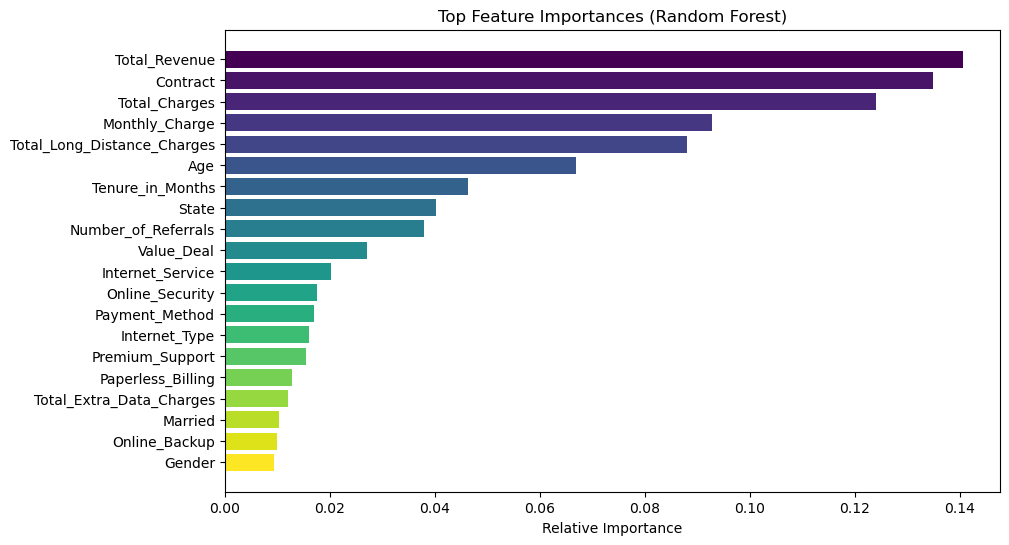

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Selection using Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_n = 20
fi = feature_importance.head(top_n)

colors = plt.cm.viridis(np.linspace(0, 1, len(fi)))

plt.figure(figsize=(10, 6))
plt.barh(fi['Feature'], fi['Importance'], color=colors)
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.title("Top Feature Importances (Random Forest)")
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [7]:
import pickle

pickle.dump(label_encoders, open("label_encoders.pkl", "wb"))
print("Encoders created and saved")

Encoders created and saved


In [8]:
import pandas as pd
import pickle
import numpy as np

#Load trained Model

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

# Get training feature names DIRECTLY from model
feature_columns = list(model.feature_names_in_)
print("Training features loaded from model:", feature_columns)

# Load label encoders

with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

# Load new data

file_path = r"C:\Users\nithi\OneDrive\Documents\Churn Analysis.xlsx"
sheet_name = "vw_JoinData"

new_data = pd.read_excel(file_path, sheet_name=sheet_name)
original_data = new_data.copy()

# Drop non-feature columns

new_data = new_data.drop(
    ['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'],
    axis=1,
    errors='ignore'
)

# Encode categorical columns safely

for col in new_data.select_dtypes(include=['object']).columns:
    if col in label_encoders:
        le = label_encoders[col]
        new_data[col] = new_data[col].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
    else:
        new_data[col] = -1

# Add missing training columns

for col in feature_columns:
    if col not in new_data.columns:
        new_data[col] = 0


# Reorder columns EXACTLY like training

new_data = new_data[feature_columns]

# Final numeric safety

new_data = new_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Predict

predictions = model.predict(new_data)

original_data['Customer_Status_Predicted'] = predictions

churned_customers = original_data[
    original_data['Customer_Status_Predicted'] == 1
]

print("Churned customers:", churned_customers.shape[0])
churned_customers.head()

Training features loaded from model: ['Gender', 'Age', 'Married', 'State', 'Number_of_Referrals', 'Tenure_in_Months', 'Value_Deal', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue']
Churned customers: 338


,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason,Customer_Status_Predicted
1,13123-BIH,Female,46,No,Bihar,13,18,Deal 5,Yes,No,...,100.199997,198.500000,0.0,10,45.119999,253.619995,Joined,Others,Others,1
2,13666-UTT,Male,57,Yes,Uttarakhand,15,16,NaN,Yes,No,...,95.400002,293.149994,0.0,0,51.029999,344.179993,Joined,Others,Others,1
3,13744-AND,Female,41,Yes,Andhra Pradesh,8,3,Deal 5,Yes,No,...,19.650000,19.650000,0.0,0,13.850000,33.500000,Joined,Others,Others,1
4,13823-TEL,Female,31,Yes,Telangana,1,28,Deal 5,No,No,...,24.500000,46.400002,0.0,0,0.000000,46.400002,Joined,Others,Others,1
5,13946-HAR,Female,41,Yes,Haryana,1,3,Deal 5,Yes,No,...,19.650000,19.650000,0.0,0,23.670000,43.320000,Joined,Others,Others,1


In [9]:
original_data['Predicted_Churn'] = original_data['Customer_Status_Predicted'].map(
    {1: 'Churn', 0: 'Not Churn'}
)



In [10]:
original_data.to_csv("Customer_Churn_Predictions_powerbi.csv", index=False)